In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
df = housing.frame
print( df.shape)
display(df.head())


(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


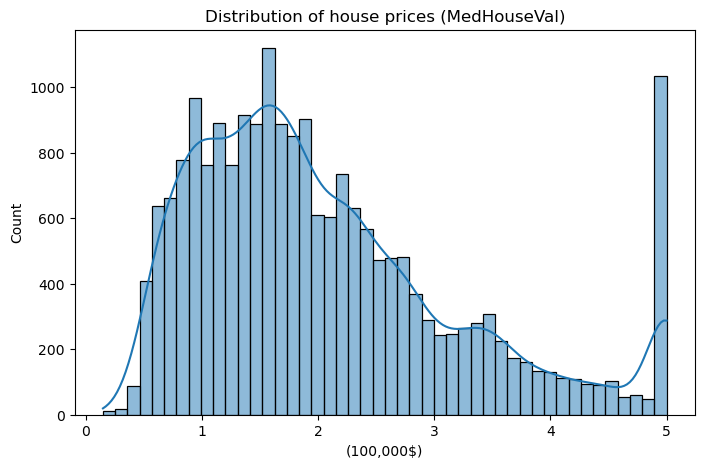

In [25]:
# Distribution of house prices
plt.figure(figsize=(8, 5))
sns.histplot(df['MedHouseVal'], kde=True)
plt.title("Distribution of house prices (MedHouseVal)")
plt.xlabel("(100,000$)")
plt.show()


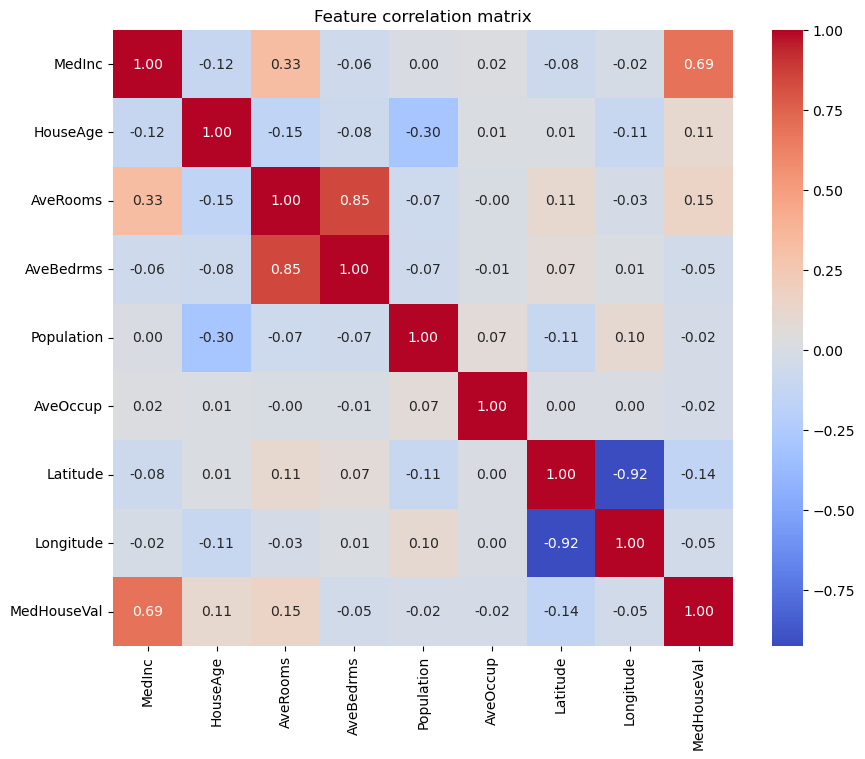

In [27]:
# Feature correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature correlation matrix")
plt.show()


In [ ]:
# Saving data to a CSV file
df.to_csv("../data/housing_clean.csv", index=False)


In [31]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Splitting the data into features (X) and target (y)
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Saving the prepared data
pd.DataFrame(X_train_scaled, columns=X.columns).to_csv("~/mlflow-housing-price/data/X_train_scaled.csv", index=False)
pd.DataFrame(X_test_scaled, columns=X.columns).to_csv("~/mlflow-housing-price/data/X_test_scaled.csv", index=False)


In [49]:
import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


input_example = X_test_scaled[0].reshape(1, -1)  # An example of input

# Stopping the previous run (if it is still active)
mlflow.end_run()

# Saving the linear regression model
with mlflow.start_run():
    # Training the linear regression model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    
    # Logging parameters and metrics
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_metric("R2", r2_score(y_test, y_pred_lr))
    
    # Calculating and logging RMSE
    mse = mean_squared_error(y_test, y_pred_lr)
    rmse = mse ** 0.5
    mlflow.log_metric("RMSE", rmse)
    
    mlflow.log_metric("MAE", mean_absolute_error(y_test, y_pred_lr))
    mlflow.sklearn.log_model(lr, "model", input_example=input_example)  # Adding input_example

# Saving the model Random Forest
with mlflow.start_run():
    # Training the Random Forest model 
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)

    # Logging parameters and metrics
    mlflow.log_param("model", "Random Forest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)
    mlflow.log_metric("R2", r2_score(y_test, y_pred_rf))
    
    # Calculating and logging RMSE
    mse = mean_squared_error(y_test, y_pred_rf)
    rmse = mse ** 0.5
    mlflow.log_metric("RMSE", rmse)
    
    mlflow.log_metric("MAE", mean_absolute_error(y_test, y_pred_rf))
    mlflow.sklearn.log_model(rf, "model", input_example=input_example)  # Adding input_example

# Saving the model XGBoost
with mlflow.start_run():
    # Training the XGBoost model
    xg_reg = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    xg_reg.fit(X_train_scaled, y_train)
    y_pred_xgb = xg_reg.predict(X_test_scaled)

    # Logging parameters and metrics
    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)
    mlflow.log_metric("R2", r2_score(y_test, y_pred_xgb))
    
    # Calculating and logging RMSE
    mse = mean_squared_error(y_test, y_pred_xgb)
    rmse = mse ** 0.5
    mlflow.log_metric("RMSE", rmse)
    
    mlflow.log_metric("MAE", mean_absolute_error(y_test, y_pred_xgb))
    xg_reg.get_booster().save_model('xgboost_model.json')  #Saving the model with a .json extension

    # Using mlflow.xgboost to save the model
    mlflow.xgboost.log_model(xg_reg, "model", input_example=input_example)  # Adding input_example


/opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [11:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
